In [1]:
import requests
import os

# 아래 url은 yahoo finance 서버에 우리나라 코스피 데이터를 요청하는 주소입니다.
url = "https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"

# 데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/kospi.csv'

# response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:  
    fp.write(response.text)

In [2]:
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 5842
삭제 후 데이터 길이(일자수): 5692


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

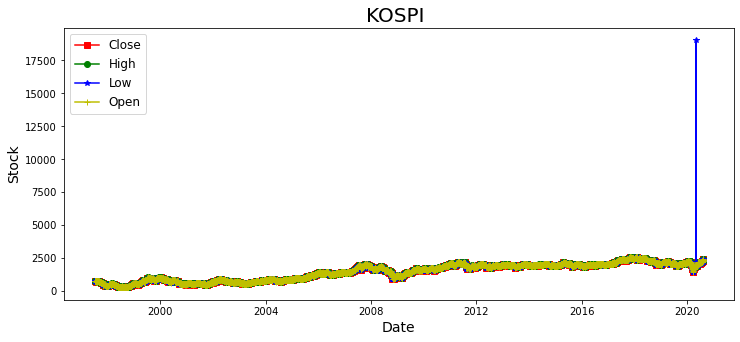

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [6]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume
5620,2020-05-06,1919.449951,1928.76001,19025.550781,1928.76001,1928.76001,1082200.0


In [7]:
# 카카오 주식차트 결과로 대체합니다. 
df.loc[df.Date == '2020-05-06', 'Low'] = 1903 

# 비정상데이터가 제거되었는지 다시 확인해 봅니다.
df.loc[df.Low>df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


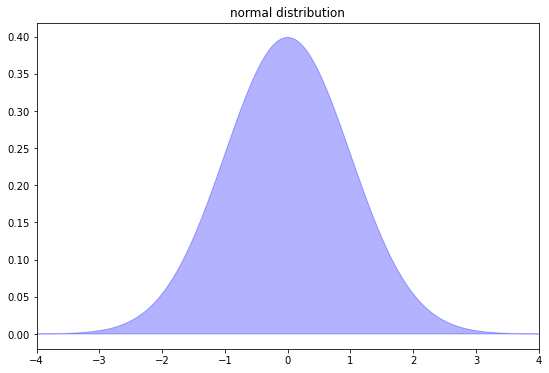

In [8]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

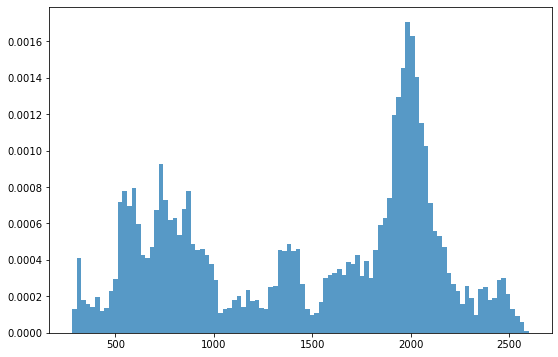

In [9]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [10]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


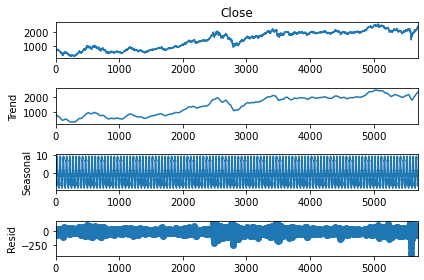

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

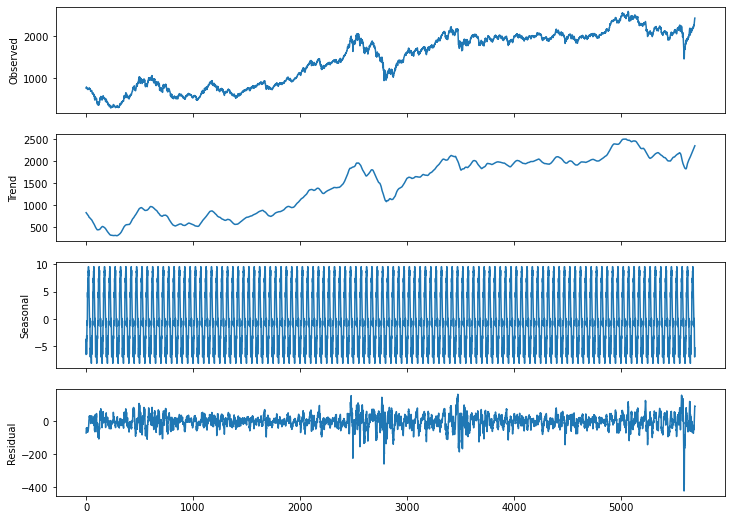

In [12]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

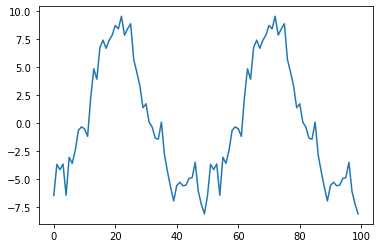

In [13]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
#-8 에서 10 사이를 주기적으로 반복하는게 보이네요.

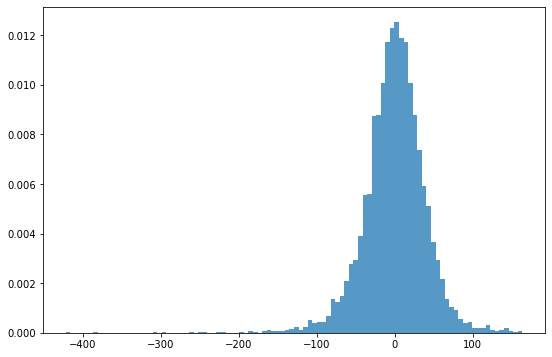

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [15]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.6804023554131796 0.4962497300226193


In [16]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -0.3595321143716522 표준편차: 39.8661527194307
이상치 갯수: 71


In [17]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

2475   2007-07-20
2476   2007-07-23
2477   2007-07-24
2478   2007-07-25
2493   2007-08-16
          ...    
5595   2020-03-26
5596   2020-03-27
5597   2020-03-30
5599   2020-04-01
5642   2020-06-05
Name: Date, Length: 71, dtype: datetime64[ns]

In [18]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,1463.295208,1472.280870,1452.027319,1462.541972,4.329729e+06
std,624.964914,625.522910,623.305110,624.550682,9.936646e+06
min,313.251601,317.456402,309.410898,313.594600,0.000000e+00
25%,829.229831,836.772549,819.689776,828.144798,3.367350e+05
50%,1650.375197,1658.997451,1638.522701,1650.718854,4.346625e+05
75%,1994.399103,2000.893924,1983.265902,1992.919778,6.528442e+05
max,2507.482712,2517.003208,2493.430989,2503.484602,4.516467e+07


In [19]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,-0.401850,-0.380359,-0.398749,-0.374020,-1.954065e+02
std,39.589372,38.056752,40.809778,39.872618,8.934869e+06
min,-394.565789,-376.338461,-411.696607,-421.422951,-2.263667e+07
25%,-21.485369,-21.030832,-21.286770,-21.477541,-2.797035e+04
50%,1.389063,1.204421,1.788349,1.088418,1.945293e+05
75%,22.442679,21.891495,23.113944,22.650363,3.611476e+05
max,166.548008,151.359456,168.724502,163.663209,3.950393e+08


In [20]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[  -0.40184982   -0.38035856   -0.39874878   -0.37402025 -195.40645742]


array([[-2.11078435e+00, -1.81469803e+00, -2.05551226e+00,
        -1.78975878e+00,  2.10763080e-02],
       [-1.57245471e+00, -1.31620670e+00, -1.54326110e+00,
        -1.29206209e+00,  3.44552935e-03],
       [-1.16743672e+00, -1.15447694e+00, -1.25272255e+00,
        -1.24664060e+00, -1.95018959e-04],
       ...,
       [ 1.40187705e+00,  2.03518846e+00,  1.80321776e+00,
         2.10596922e+00,  6.12871509e-02],
       [ 1.72956122e+00,  1.93639106e+00,  1.59747384e+00,
         2.26635573e+00,  3.75265169e-02],
       [ 2.56782539e+00,  2.43952406e+00,  1.89411956e+00,
         2.24061341e+00,  1.51850684e-02]])

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [22]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[3258 2434]


In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1002',
 'group:1-count:535',
 'group:2-count:47',
 'group:3-count:2',
 'group:4-count:336',
 'group:5-count:868',
 'group:6-count:210',
 'group:7-count:820',
 'group:8-count:8',
 'group:9-count:142',
 'group:10-count:1007',
 'group:11-count:55',
 'group:12-count:2',
 'group:13-count:591',
 'group:14-count:67']

In [24]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==8)|(kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
1607,2004-01-20,854.030029,864.260010,853.049988,861.369995,861.369995,364449900.0
1663,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0
2737,2008-08-14,1553.650024,1578.300049,1553.650024,1572.189941,1572.189941,247586000.0
2738,2008-08-18,1579.130005,1582.760010,1561.569946,1567.709961,1567.709961,260725000.0
2786,2008-10-27,937.179993,966.409973,892.159973,946.450012,946.450012,540600.0
2787,2008-10-28,916.849976,1012.729980,901.489990,999.159973,999.159973,649400.0
5588,2020-03-17,1640.839966,1722.969971,1637.880005,1672.439941,1672.439941,649800.0
5589,2020-03-18,1686.119995,1693.949951,1591.119995,1591.199951,1591.199951,728000.0
5590,2020-03-19,1626.089966,1626.089966,1439.430054,1457.640015,1457.640015,977700.0
5591,2020-03-20,1498.489990,1566.819946,1466.479980,1566.150024,1566.150024,817000.0


In [25]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,1462.901104,1471.908189,1451.636816,1462.175989,1462.175989,4.329776e+06
std,627.457157,627.898094,625.928464,627.087928,627.087928,1.351615e+07
min,283.410004,291.010010,277.369995,280.000000,280.000000,0.000000e+00
25%,827.972473,836.750000,815.689987,826.737503,826.737503,3.126000e+05
50%,1652.270019,1658.365051,1633.690002,1646.915039,1646.915039,4.103000e+05
75%,1999.605011,2006.892517,1988.862488,1997.255005,1997.255005,6.145500e+05
max,2590.409912,2607.100098,2587.550049,2598.189941,2598.189941,4.071570e+08


In [26]:
# 2004-04-14 주변 정황
df.iloc[1660:1670]

,Date,Open,High,Low,Close,Adj Close,Volume
1660,2004-04-09,910.479980,910.479980,901.239990,905.440002,905.440002,352200.0
1661,2004-04-12,905.440002,926.070007,905.440002,918.859985,918.859985,366200.0
1662,2004-04-13,925.190002,927.669983,916.200012,917.630005,917.630005,469000.0
1663,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0
1664,2004-04-16,903.840027,908.719971,897.729980,898.880005,898.880005,391800.0
1665,2004-04-19,900.479980,902.099976,891.270020,902.099976,902.099976,476200.0
1666,2004-04-20,909.909973,919.130005,902.469971,918.900024,918.900024,456800.0
1667,2004-04-21,910.679993,931.210022,910.679993,929.950012,929.950012,554000.0
1668,2004-04-22,931.090027,933.840027,921.969971,924.010010,924.010010,519800.0
1669,2004-04-23,938.250000,939.520020,929.799988,936.059998,936.059998,480400.0


In [28]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.082112,-0.092739,-0.078163,-0.087114,-0.063000
1,1.144757,1.164607,1.126808,1.133456,0.008482
2,-3.345688,-3.302405,-3.670760,-3.494020,0.004189
3,1.404885,1.474385,1.540287,1.527861,27.050550
4,-1.406206,-1.450260,-1.419465,-1.434598,-0.102974
5,-0.466282,-0.483060,-0.456106,-0.459764,-0.060207
6,1.765868,1.834539,1.780621,1.788096,0.117591
7,0.665708,0.683950,0.669692,0.672248,-0.025536
8,-7.397073,-6.966336,-7.659620,-7.181657,-0.037365
9,-2.175945,-2.210252,-2.189755,-2.158304,-0.121632


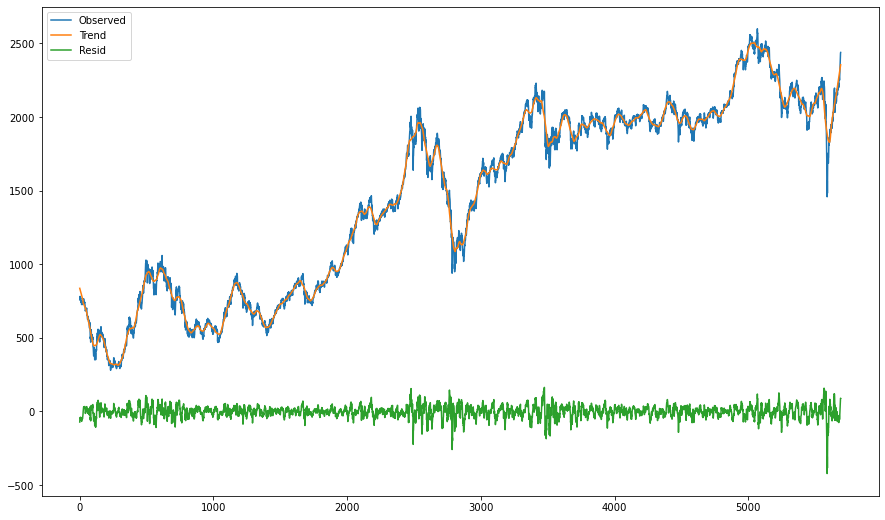

In [29]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

In [30]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [31]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[0 0 0 ... 0 0 0]


In [32]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:41',
 'group:0-count:5646',
 'group:1-count:3',
 'group:2-count:2']

In [33]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [34]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [35]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [36]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [37]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [38]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [39]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 0.4352 - mae: 0.4352
Epoch 00001: val_loss improved from inf to 0.06894, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
178/178 [==============================] - 5s 29ms/step - loss: 0.4352 - mae: 0.4352 - val_loss: 0.0689 - val_mae: 0.0689
Epoch 2/50
177/178 [============================>.] - ETA: 0s - loss: 0.1521 - mae: 0.1521
Epoch 00002: val_loss did not improve from 0.06894
178/178 [==============================] - 5s 27ms/step - loss: 0.1532 - mae: 0.1532 - val_loss: 0.1126 - val_mae: 0.1126
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.1504 - mae: 0.1504
Epoch 00003: val_loss improved from 0.06894 to 0.06530, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
178/178 [==============================] - 5s 28ms/step - loss: 0.1504 - mae: 0.1504 - val_loss: 0.0653 - val_mae: 0.0653
Epoch 4/50
178/178 [============================

In [40]:
model.load_weights(checkpoint_path)

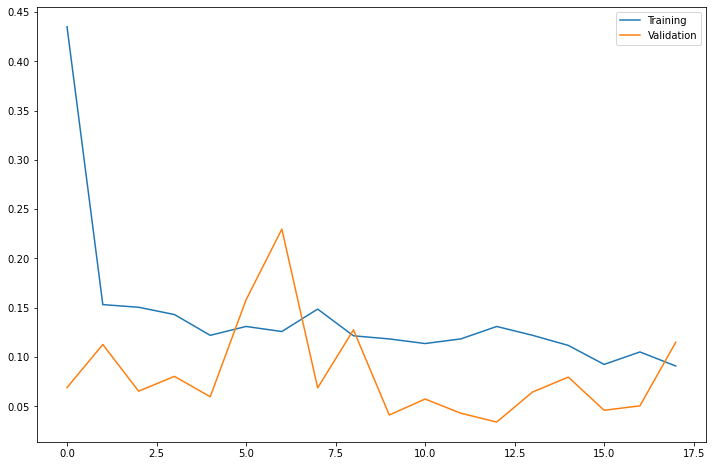

In [41]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

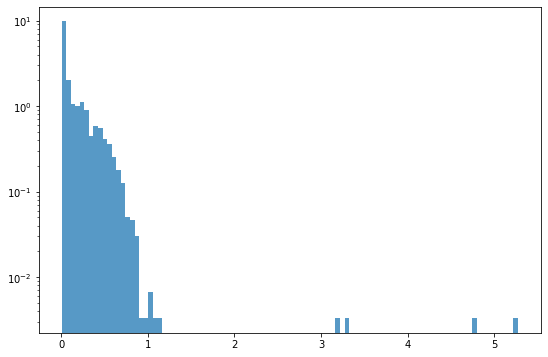

In [42]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [43]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1597,2004-01-20,854.030029,864.260010,853.049988,861.369995,861.369995,364449900.0,4.755125
1653,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0,5.275541
2727,2008-08-14,1553.650024,1578.300049,1553.650024,1572.189941,1572.189941,247586000.0,3.175569
2728,2008-08-18,1579.130005,1582.760010,1561.569946,1567.709961,1567.709961,260725000.0,3.318167


In [44]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
32,1997-09-01,691.799988,697.380005,682.099976,682.200012,682.200012,0.0,0.303385
33,1997-09-02,679.090027,688.780029,671.090027,688.780029,688.780029,0.0,0.306634
45,1997-09-23,666.559998,666.559998,654.369995,654.369995,654.369995,0.0,0.300641
46,1997-09-24,653.299988,658.580017,645.469971,655.750000,655.750000,0.0,0.307891
47,1997-09-25,655.219971,658.780029,643.309998,647.000000,647.000000,0.0,0.305963
...,...,...,...,...,...,...,...,...
3471,2011-08-09,1807.880005,1828.630005,1684.680054,1801.349976,1801.349976,685000.0,0.352531
5576,2020-03-13,1722.680054,1809.310059,1680.599976,1771.439941,1771.439941,1035300.0,0.317707
5578,2020-03-17,1640.839966,1722.969971,1637.880005,1672.439941,1672.439941,649800.0,0.310749
5580,2020-03-19,1626.089966,1626.089966,1439.430054,1457.640015,1457.640015,977700.0,0.372660


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


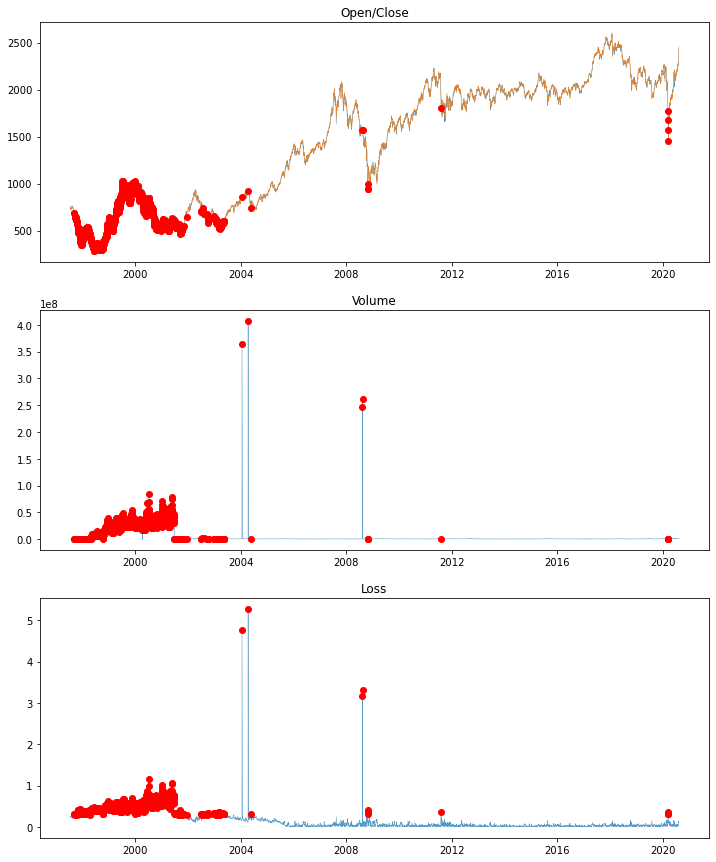

In [45]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])